## Pix2pix image colorization. 
#### Examples using pre-trained generator model and a collection of images that are in the training and outside the training set. Also getting results analyzed via histogram comparsions and attempting to colorize webcam mjpeg stream in real time.

https://github.com/skirdey/mxnet-pix2pix - code to train pix2pix using MXNet and Python 3.6, it also visualizes training process via cv2 library

The network was trained on a set of 36000 256x256 images mostly covering city streets and city scape. The images were extracted from a video at about 4fps. The training process took approximately 20 hours on a laptop with Nvidia Geforce GTX 1060 with 6GB of video memory. 

Skinny of the tutorial:
1. Load an image
2. Convert to lab and extract lightness
3. Run lightness through pre-trained pix2pix generator
4. Display and analyize colorization result
5. Colorize video captchured from a live web-cam in real-time and display an example. 

#### Demo of real-time colorization ( not real time anymore ). Video stream came from a web camera attached to the computer. 
https://s3-us-west-1.amazonaws.com/pix2pix/real_time_video_colorization_street.gif

In [1]:
from IPython.display import HTML
HTML('<img src="https://s3-us-west-1.amazonaws.com/pix2pix/real_time_video_colorization_street.gif">')

#### Demo of real-time colorization ( not real time anymore ). Video stream came from an online web camera.
https://s3-us-west-1.amazonaws.com/pix2pix/real_time_video_colorization.gif

In [2]:
from IPython.display import HTML
HTML('<img src="https://s3-us-west-1.amazonaws.com/pix2pix/real_time_video_colorization.gif">')

#### Let's start!

In [3]:
%matplotlib inline
import logging
import os
import glob
import cv2
import time
import mxnet as mx
import mxnet.ndarray as nd
from mxnet import gluon
from mxnet import autograd
import numpy as np
from datetime import datetime
from PIL import Image
from zope.interface import implementer

import matplotlib
import matplotlib.pyplot as plt

from cv2_utils import show_mxnet_to_numpy_array, show_numpy_array
from util import rgb_to_lab
from util.process_lab_utils_mx import preprocess_lab
from util.process_lab_utils_np import lab_parts_to_rgb

from network.gluon_pix2pix_modules import UnetGenerator, Discriminator
from report.Metric import Metric
from util.process_lab_utils_np import lab_parts_to_rgb
from util.visual_utils import visualize_cv2
from network.neural_network_interface import NeuralNetworkInterface
from util.lab_color_utils_mx import rgb_to_lab

Importing necessary utilities and system modules. We are doing lab colorization, meaning we will convert an image into the lab space and use the lightness channel to run it through a generator. The network, traning, and helper classed can be found here - https://github.com/skirdey/mxnet-pix2pix

In [4]:
ctx = mx.cpu(0)

#### Helper functions
What we are doing here is loading a pre-trained generator model, and binding data parameters to it.
We also have several functions to load an image, either jpeg or png, and get is lightness channel that we can run through generator network. 

In [5]:
def timeme(method):
    def wrapper(*args, **kw):
        startTime = time.time()
        result = method(*args, **kw)
        endTime = time.time()
        print(str(method.__name__) + ": ", endTime - startTime , 'seconds')
        return result
    return wrapper

In [6]:
def load_generator_from_checkpoint(position):
    filename_net_g = "netG{}".format(position)
    net_g = UnetGenerator(in_channels=1, num_downs=8, final_out=2) # 2 channels, a and b - for colorization
    assert net_g
    net_g.load_params(filename_net_g, ctx=ctx)
    assert net_g
    net_g.hybridize()
    return net_g

In [7]:
 def prepare_real_in(batch):
    real_a = batch.data[0]
    lab = rgb_to_lab(real_a, ctx=ctx)
    lightness_chan, a_chan, b_chan = preprocess_lab(lab)
    real_in = nd.expand_dims(lightness_chan, axis=2)
    real_in = real_in.transpose((3, 2, 0, 1))
    return real_in

In [8]:
def load_image(image_filename):
    assert image_filename
    with open(image_filename, 'rb') as fp:
        str_image = fp.read()

    return mx.img.imdecode(str_image)

##### Note
Get color channels function uses internal helper functions to process an RGB image into LAB space. 
It also resizes an image into 256 by 256 square so we can run it through the generator network. 
Before returning the result, we resize the generator's output back to image's original size. 
As generator expects a square image, it is best to operate on square sample images to test out colorization. 

In [9]:
@timeme
def generator_run(model, image):
    return model(prepare_real_in(mx.io.DataBatch([image]))) # ugly, but allows for code re-use

In [10]:
def get_real_A(real_in):
    real_a = real_in
    real_a = nd.cast(real_a, "uint8")

    real_a = real_a.transpose((0, 2, 3, 1))
    real_a = nd.array(np.squeeze(real_a.asnumpy(), axis=0), ctx=self.ctx)
    lab = rgb_to_lab(real_a, ctx=self.ctx)
    lightness_chan, a_chan, b_chan = preprocess_lab(lab)

    real_in = nd.expand_dims(lightness_chan, axis=2)
    real_in = real_in.transpose((3, 2, 0, 1))

In [11]:
def get_color_channels(image, model):
    w, h = image.shape[0:2]

    if image.shape[0:2] != (256, 256):
        image = mx.image.resize_short(image, 256)
        image = mx.image.center_crop(image, (256, 256))[0]

    output = generator_run(model, image)
    
    a_b_channels = squeeze_mx_image(output).transpose((2,1,0))

    a_b_channels = cv2.resize(a_b_channels.asnumpy(), (w, h))
    a_b_channels = nd.expand_dims(nd.array(a_b_channels), axis=2).transpose((2, 3, 1, 0))
    return a_b_channels

In [12]:
def squeeze_mx_image(image):
    return nd.array(np.squeeze(image.asnumpy(), axis=0), ctx=ctx)

In [13]:
def get_lightness(image):
    image = image.as_in_context(ctx)
    lab = rgb_to_lab(image, ctx=ctx)
    lightness_chan, _, _ = preprocess_lab(lab)
    return lightness_chan

In [14]:
def colorize_image(real_a, model):
    real_a = nd.cast(real_a, "uint8")
    color_channels = get_color_channels(real_a, model)
    original_size_lightness = get_lightness(real_a)

    grayscale_lightness = nd.expand_dims(original_size_lightness, axis=2).transpose((3,2,0,1))

    fake_rgb = lab_parts_to_rgb(color_channels.asnumpy() * 1, grayscale_lightness.asnumpy(), ctx)
    
    return fake_rgb

#### Moment of truth
Let's load an image that I've taken on my phone, cropped it to a square and resized to 512x512. The neural net never seen this picture before. It was quite new for me as well - sunny in Seattle!

#### A bit on Pix2pix
Pix2pix approach is based on two neural networks, that are trained at the same time. 

Generator network in a original GAN is a model that learns mapping from random noise vector $z$ to output image $y$:

$$G : z \rightarrow y$$

Pix2pix uses approach of conditional GANS, where generator learns mapping from original image $x$ and random noise vector $z$ to original image $y$:

$$ G : {x, z} \rightarrow y$$

The objective of a pix2pix training is $G^{∗}= arg\,\underset{G}{min}\,\underset{D}{max}\,\mathcal{L}_{cGAN} (G, D) \,+\, \alpha\times \mathcal{L}_{L1}(G)$

The objective stands for use gradient 'ascent' on Discriminator and *increase* the probability of detecting fakes and recognizes real pictures, and use gradient descent on the generator to decrease the probability to be detected as a fake. 

In [15]:
model = load_generator_from_checkpoint(100)
real = load_image("./test_img/IMG-2268.JPG")
colorized =  colorize_image(real, model)

generator_run:  0.019622087478637695 seconds


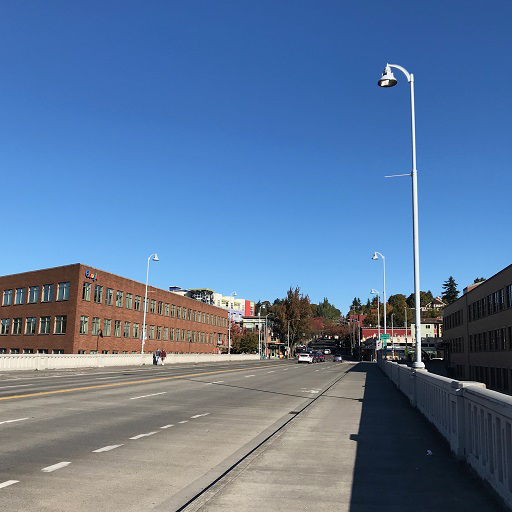

In [16]:
# Original, straight from the phone
real = real.asnumpy() # It has type MXNet.NDArray at this point
Image.fromarray(real)

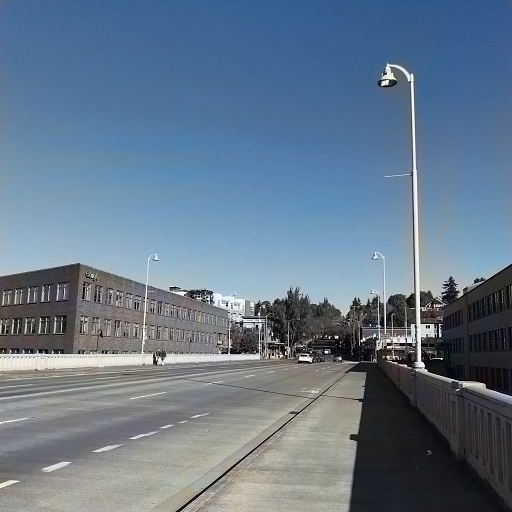

In [17]:
# Colorized version
Image.fromarray(colorized)

#### Metrics
It is nice to see the result visually. And it is nice to see some quanitifed metrics. We can have rgb histogram comparsions between original and colorized version, and also an L1 difference between the fake and the real images. It also make sense to time the colorization call itself, and see how fast it performs its task. Lets start with it:

#### Histograms

/Users/stan/anaconda3/envs/deeply/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


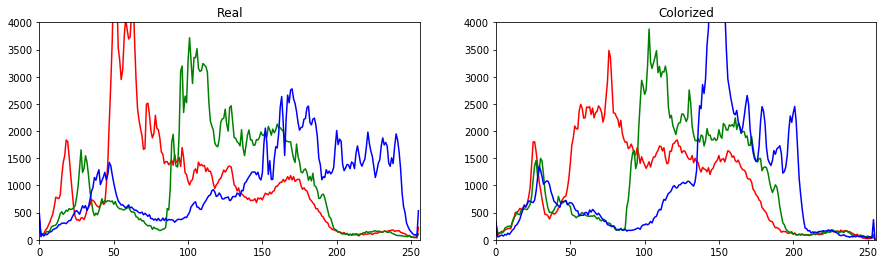

In [18]:
import matplotlib.patches as mpatches
red_patch = mpatches.Patch(color='red')
green_patch = mpatches.Patch(color='green')
blue_patch = mpatches.Patch(color='blue')

color = ('r','g','b')
plt.figure(figsize=(15,4))
for channel, col in enumerate(color):
    histr_real = cv2.calcHist([real], [channel], None, [256], [0,256])
    histr_colorized = cv2.calcHist([colorized], [channel], None, [256], [0,256])
    
    plt.xlim([0,256])
    plt.ylim([0,4000])
    plt.subplot(1, 2, 1) # plt.subplot allows us to plot side by side, the args are (row, col, current plot)
    plt.title("Real")
    plt.plot(histr_real,color = col)
    
    plt.xlim([0,256])
    plt.ylim([0,4000])
    plt.subplot(1,2,2)
    plt.title("Colorized")
    plt.plot(histr_colorized, color = col)
    

plt.show()

Just for the test, lets make sure the histogram of real image has correlation of 1 
to itself, and do the same for the colorized version 

Let's compute the difference numerically using OpenCV compareHist function. 
https://docs.opencv.org/2.4/modules/imgproc/doc/histograms.html?highlight=comparehist#comparehist

In [19]:
# Comparing all three color channels at once
histr_real = cv2.calcHist([real], [0,1,2], None, [256, 256, 256], [0,256, 0, 256, 0, 256])
histr_colorized = cv2.calcHist([colorized], [0,1,2], None, [256, 256, 256], [0,256, 0, 256, 0, 256])


cv2.compareHist(histr_real, histr_real, 0)

In [20]:
cv2.compareHist(histr_colorized, histr_colorized, 0)

1.0

At least we know that correlation functions works on two identical histograms. 
Lets try it on real and colorized images. Correlatiom method performs following computation:

### Correlation metric
[-1:1], 1 being perfect match

$$d(H_1,H_2) =  \frac{\sum_I (H_1(I) - \bar{H_1}) (H_2(I) - \bar{H_2})}{\sqrt{\sum_I(H_1(I) - \bar{H_1})^2 \sum_I(H_2(I) - \bar{H_2})^2}}$$ where $$\bar{H_k} =  \frac{1}{N} \sum _J H_k(J)$$ and $N$ is a total number of bins. 

In [21]:
cv2.compareHist(histr_real, histr_colorized, 0)

-0.03828964634863742

-0.27 - Not great, but not bad. The colorized image looks like a badly taken photo, but the colors there do make sense.

### Chi-Square
[0: positive infinity], 0 is perfect match
It computes $$d(H_1,H_2) =  \sum _I  \frac{\left(H_1(I)-H_2(I)\right)^2}{H_1(I)}$$

In [22]:
cv2.compareHist(histr_real, histr_colorized, 1)

416210.1492577328

### Bhattacharyya distance
[-1: 1], 0 is perect match
$$d(H_1,H_2) =  \sqrt{1 - \frac{1}{\sqrt{\bar{H_1} \bar{H_2} N^2}} \sum_I \sqrt{H_1(I) \cdot H_2(I)}}$$

In [23]:
cv2.compareHist(histr_real, histr_colorized, 3)

0.9712936492484769

0.8798752374385485 - far away from a perfect match. Still, visually colorization result doesn't feel that wrong. 

### Video colorization on the client in a browser

In [24]:
# %matplotlib notebook
# import signal

In [25]:
# def signal_handler(signal, frame):
#     # KeyboardInterrupt detected, exiting
#     global is_interrupted
#     is_interrupted = True

In [26]:
# one_more_url = "http://217.197.157.7:7070/axis-cgi/mjpg/video.cgi?resolution=320x240"
# url = "http://85.46.64.147/axis-cgi/mjpg/video.cgi?camera=&resolution=320x240" # looks like italy
# vc = cv2.VideoCapture('./test_video/test_video_1.mp4')

# plt.ion()

# # if vc.isOpened(): # try to get the first frame
# #     is_capturing, frame = vc.read()
    
# #     frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)    # makes the blues image look real colored
# #     frame_colorized = colorize_image(nd.array(frame), model)
    
# #     plt.figure(figsize=(15,5))
# #     plt.subplot(1, 2, 1)
# #     webcam_preview_original = plt.imshow(frame)
# #     plt.subplot(1, 2, 2)
# #     webcam_preview_colorized = plt.imshow(frame_colorized)    
# # else:
# #     is_capturing = False

# signal.signal(signal.SIGINT, signal_handler)
# is_interrupted = False
# while is_capturing:
#     is_capturing, frame = vc.read() 
    
#     frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)    # makes the blues image look real colored
#     frame_colorized = colorize_image(nd.array(frame), model)
    
#     webcam_preview_original.set_data(frame)
#     webcam_preview_colorized.set_data(frame_colorized)
    
#     plt.show()

#     try:    # Avoids a NotImplementedError caused by `plt.pause`
#         plt.pause(0.05)
#     except Exception:
#         pass
#     if is_interrupted:
#         vc.release()
#         break

# Let's process a sample video file

In [28]:
# Define the codec and create VideoWriter object
import time
input_video = "trim_40s.mp4"
output = "output.mp4"
width = 256
height = 256
fourcc = cv2.VideoWriter_fourcc(*'mp4v') # Be sure to use lower case
out = cv2.VideoWriter(output, fourcc, 20.0, (width, height))

In [29]:
cap = cv2.VideoCapture(input_video)

while(cap.isOpened()):
    ret, frame = cap.read()
    if frame is not None and frame.shape == (256, 256, 3):
#         frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame_colorized = colorize_image(nd.cast(nd.array(frame), "uint8"), model)
        frame_colorized = cv2.cvtColor(frame_colorized, cv2.COLOR_BGR2RGB)
        out.write(frame_colorized)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
out.release()

cv2.destroyAllWindows()

generator_run:  0.013715982437133789 seconds
generator_run:  0.009795188903808594 seconds
generator_run:  0.00957798957824707 seconds
generator_run:  0.009350776672363281 seconds
generator_run:  0.00916600227355957 seconds
generator_run:  0.009917020797729492 seconds
generator_run:  0.009139060974121094 seconds
generator_run:  0.00954890251159668 seconds
generator_run:  0.01131582260131836 seconds
generator_run:  0.00900721549987793 seconds
generator_run:  0.009773731231689453 seconds
generator_run:  0.010751008987426758 seconds
generator_run:  0.00704503059387207 seconds
generator_run:  0.01030278205871582 seconds
generator_run:  0.010575056076049805 seconds
generator_run:  0.009260892868041992 seconds
generator_run:  0.009701728820800781 seconds
generator_run:  0.009137868881225586 seconds
generator_run:  0.00660395622253418 seconds
generator_run:  0.010021209716796875 seconds
generator_run:  0.009588241577148438 seconds
generator_run:  0.009756326675415039 seconds
generator_run:  0.

generator_run:  0.010035991668701172 seconds
generator_run:  0.010722160339355469 seconds
generator_run:  0.009349822998046875 seconds
generator_run:  0.010604143142700195 seconds
generator_run:  0.010326147079467773 seconds
generator_run:  0.006594181060791016 seconds
generator_run:  0.009374856948852539 seconds
generator_run:  0.009443044662475586 seconds
generator_run:  0.006524085998535156 seconds
generator_run:  0.010007858276367188 seconds
generator_run:  0.009549140930175781 seconds
generator_run:  0.009123802185058594 seconds
generator_run:  0.009297370910644531 seconds
generator_run:  0.010410070419311523 seconds
generator_run:  0.011239767074584961 seconds
generator_run:  0.007539987564086914 seconds
generator_run:  0.013825654983520508 seconds
generator_run:  0.00937509536743164 seconds
generator_run:  0.009268999099731445 seconds
generator_run:  0.009229183197021484 seconds
generator_run:  0.009016990661621094 seconds
generator_run:  0.009431123733520508 seconds
generator_r

generator_run:  0.008983850479125977 seconds
generator_run:  0.009165048599243164 seconds
generator_run:  0.00973200798034668 seconds
generator_run:  0.009128332138061523 seconds
generator_run:  0.00920414924621582 seconds
generator_run:  0.010471105575561523 seconds
generator_run:  0.009052038192749023 seconds
generator_run:  0.009164094924926758 seconds
generator_run:  0.00895380973815918 seconds
generator_run:  0.009147167205810547 seconds
generator_run:  0.009027957916259766 seconds
generator_run:  0.009071826934814453 seconds
generator_run:  0.009133100509643555 seconds
generator_run:  0.010646820068359375 seconds
generator_run:  0.00893712043762207 seconds
generator_run:  0.009115934371948242 seconds
generator_run:  0.009109973907470703 seconds
generator_run:  0.009443998336791992 seconds
generator_run:  0.009117841720581055 seconds
generator_run:  0.009067773818969727 seconds
generator_run:  0.009019136428833008 seconds
generator_run:  0.011083126068115234 seconds
generator_run:

generator_run:  0.01073598861694336 seconds
generator_run:  0.01050114631652832 seconds
generator_run:  0.009496688842773438 seconds
generator_run:  0.0072209835052490234 seconds
generator_run:  0.00917816162109375 seconds
generator_run:  0.00899195671081543 seconds
generator_run:  0.01081991195678711 seconds
generator_run:  0.010114908218383789 seconds
generator_run:  0.009840250015258789 seconds
generator_run:  0.009131669998168945 seconds
generator_run:  0.0065419673919677734 seconds
generator_run:  0.010288000106811523 seconds
generator_run:  0.010112762451171875 seconds
generator_run:  0.00897216796875 seconds
generator_run:  0.009011983871459961 seconds
generator_run:  0.006606101989746094 seconds
generator_run:  0.009180307388305664 seconds
generator_run:  0.009078025817871094 seconds
generator_run:  0.009057998657226562 seconds
generator_run:  0.009059667587280273 seconds
generator_run:  0.01156473159790039 seconds
generator_run:  0.012997865676879883 seconds
generator_run:  0.

generator_run:  0.010879993438720703 seconds
generator_run:  0.009501934051513672 seconds
generator_run:  0.011408090591430664 seconds
generator_run:  0.012032032012939453 seconds
generator_run:  0.007561922073364258 seconds
generator_run:  0.010459184646606445 seconds
generator_run:  0.010614156723022461 seconds
generator_run:  0.01146697998046875 seconds
generator_run:  0.00937199592590332 seconds
generator_run:  0.009869098663330078 seconds
generator_run:  0.010481834411621094 seconds
generator_run:  0.009241819381713867 seconds
generator_run:  0.0063648223876953125 seconds
generator_run:  0.011322021484375 seconds
generator_run:  0.007077932357788086 seconds
generator_run:  0.009947061538696289 seconds
generator_run:  0.009910106658935547 seconds
generator_run:  0.00967097282409668 seconds
generator_run:  0.009915828704833984 seconds
generator_run:  0.00997304916381836 seconds
generator_run:  0.009618759155273438 seconds
generator_run:  0.009779930114746094 seconds
generator_run:  

generator_run:  0.009008169174194336 seconds
generator_run:  0.009952068328857422 seconds
generator_run:  0.008944272994995117 seconds
generator_run:  0.009573221206665039 seconds
generator_run:  0.009902000427246094 seconds
generator_run:  0.009488105773925781 seconds
generator_run:  0.010687112808227539 seconds
generator_run:  0.010568857192993164 seconds
generator_run:  0.008807897567749023 seconds
generator_run:  0.008947372436523438 seconds
generator_run:  0.00966501235961914 seconds
generator_run:  0.009080171585083008 seconds
generator_run:  0.009725809097290039 seconds
generator_run:  0.009007930755615234 seconds
generator_run:  0.00897216796875 seconds
generator_run:  0.009813070297241211 seconds
generator_run:  0.009370803833007812 seconds
generator_run:  0.010303974151611328 seconds
generator_run:  0.008985757827758789 seconds
generator_run:  0.009057044982910156 seconds
generator_run:  0.00974273681640625 seconds
generator_run:  0.009712934494018555 seconds
generator_run:  

generator_run:  0.009311914443969727 seconds
generator_run:  0.009585142135620117 seconds
generator_run:  0.009025812149047852 seconds
generator_run:  0.009814023971557617 seconds
generator_run:  0.01031804084777832 seconds
generator_run:  0.009885787963867188 seconds
generator_run:  0.009188175201416016 seconds
generator_run:  0.00976109504699707 seconds
generator_run:  0.0102691650390625 seconds
generator_run:  0.009935855865478516 seconds
generator_run:  0.008947134017944336 seconds
generator_run:  0.009716033935546875 seconds
generator_run:  0.00936126708984375 seconds
generator_run:  0.010745048522949219 seconds
generator_run:  0.008994102478027344 seconds
generator_run:  0.008959054946899414 seconds
generator_run:  0.009007930755615234 seconds
generator_run:  0.010008096694946289 seconds
generator_run:  0.009024858474731445 seconds
generator_run:  0.00970602035522461 seconds
generator_run:  0.009512901306152344 seconds
generator_run:  0.010196924209594727 seconds
generator_run:  

generator_run:  0.009730100631713867 seconds
generator_run:  0.008993148803710938 seconds
generator_run:  0.009770870208740234 seconds
generator_run:  0.008985042572021484 seconds
generator_run:  0.010287761688232422 seconds
generator_run:  0.009971857070922852 seconds
generator_run:  0.009301185607910156 seconds
generator_run:  0.00957798957824707 seconds
generator_run:  0.00981903076171875 seconds
generator_run:  0.008942842483520508 seconds
generator_run:  0.00968313217163086 seconds
generator_run:  0.009323835372924805 seconds
generator_run:  0.010851144790649414 seconds
generator_run:  0.009746789932250977 seconds
generator_run:  0.009065866470336914 seconds
generator_run:  0.009365081787109375 seconds
generator_run:  0.00927591323852539 seconds
generator_run:  0.010383129119873047 seconds
generator_run:  0.01026606559753418 seconds
generator_run:  0.01017904281616211 seconds
generator_run:  0.009089946746826172 seconds
generator_run:  0.009026765823364258 seconds
generator_run:  

generator_run:  0.009215116500854492 seconds
generator_run:  0.00940704345703125 seconds
generator_run:  0.010778188705444336 seconds
generator_run:  0.010904073715209961 seconds
generator_run:  0.009693145751953125 seconds
generator_run:  0.010265827178955078 seconds
generator_run:  0.009387969970703125 seconds
generator_run:  0.00915670394897461 seconds
generator_run:  0.00991201400756836 seconds
generator_run:  0.009783029556274414 seconds
generator_run:  0.009943008422851562 seconds
generator_run:  0.009418010711669922 seconds
generator_run:  0.010025978088378906 seconds
generator_run:  0.013566017150878906 seconds
generator_run:  0.00948786735534668 seconds
generator_run:  0.009463787078857422 seconds
generator_run:  0.008978843688964844 seconds
generator_run:  0.009588956832885742 seconds
generator_run:  0.00926518440246582 seconds
generator_run:  0.009521007537841797 seconds
generator_run:  0.009490013122558594 seconds
generator_run:  0.009539127349853516 seconds
generator_run: 

KeyboardInterrupt: 